# 10 classes, Hellinger distance, MNIST

In [90]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from keras.datasets import mnist
import itertools
import codecs
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [95]:
def factorial(n):
    if n == 0:
        return 1
    elif n > 0:
        return n*factorial(n - 1)

In [96]:
# entropy labelling
def tsallis_label(q, probas, s_cls):
    elements = np.power(probas, q - 1)
    # thrshld in tsallis entropy model
    ts_thrshld = np.sum(np.power(probas, q))
    if q < 1:
        labels = [s_cls[i] for i, e in enumerate(elements) if e < ts_thrshld]
    else:
        labels = [s_cls[i] for i, e in enumerate(elements) if e > ts_thrshld]
    return labels

In [97]:
# 1/M labelling
def oneMth_label(probas, s_cls):
    # 1/M
    thrshld = 1/len(s_cls)
    labels = [s_cls[i] for i, pk in enumerate(probas) if pk > thrshld]
    return labels

In [98]:
def shannon_label(probas, s_cls):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    if isnan(Hp):
        labels = [s_cls[np.argmax(probas)]]
    else:
        labels = [s_cls[i] for i, Ipk in enumerate(info_con) if Ipk <= Hp]
    return labels

In [99]:
# labelling and evaluating them
def info_trans_scoring(q, classes, orig_A, lim_A, dataset):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    if (dataset == "mnist"):
        a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    else:
        a1_model = LR(max_iter = 300).fit(trn_imgs[:orig_A], trn_labels[:orig_A])
        
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # labelling
    if (q == 0): # 1/M
        mul_labels = [oneMth_label(probas, s_cls) for probas in a1_probas]
    elif (q == 1): # shannon
        mul_labels = [shannon_label(probas, s_cls) for probas in a1_probas]
    else: # regular tsallis
        mul_labels = [tsallis_label(q, probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power((np.sqrt(probas[s_cls.index(label)]) - np.sqrt(u_dist)), 2)
    
    return np.sqrt(score)/np.sqrt(2)

In [100]:
# fop top-r (1.2, 1.4, 1.6, 1.8)
from sklearn.model_selection import train_test_split

# labelling and evaluating them
def info_trans_scoring_3(part, classes, orig_A, lim_A, dataset):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    # generate an annotator
    if (dataset == "mnist"):
        ann_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    else:
        ann_model = LR(max_iter = 300).fit(trn_imgs[:orig_A], trn_labels[:orig_A])

    # labelling
    f_imgs, s_imgs, f_labels, s_labels = train_test_split(trn_imgs[orig_A:orig_A + lim_A], trn_labels[orig_A:orig_A + lim_A], test_size = part/100)
    # top-1
    f_ann_proba = ann_model.predict_proba(f_imgs)
    ord_labels = [topk_label(probas, s_cls, 1) for probas in f_ann_proba]
    # top-2
    s_ann_proba = ann_model.predict_proba(s_imgs)
    top2_labels = [topk_label(probas, s_cls, 2) for probas in s_ann_proba]
    # concat top-1 results and top-2 results
    ann_probas = ann_model.predict_proba(f_imgs + s_imgs)
    mul_labels = ord_labels + top2_labels
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, ann_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power((np.sqrt(probas[s_cls.index(label)]) - np.sqrt(u_dist)), 2)
    
    return np.sqrt(score)/np.sqrt(2)

In [10]:
# loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

### q = -1.0, -0.1, 0, 0.1, 1.0 

In [18]:
# main measurement
from math import isnan # for shannon

classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "mnist"

q_list = [-1.0, -0.1, 0, 0.1, 1]
results = [info_trans_scoring(q, classes, orig_A1, lim_A1, dataset) for q in q_list]
print(results)

[31.515281268279736, 9.885849848745657, 2.567830217165451, 1.4024960668440367, 2.9529449627044273]


### q = +inf (Top-1)

In [32]:
# top-k labelling
def topk_label(probas, s_cls, k):
    l_indexes = probas.argsort()[::-1][:k]
    labels = [s_cls[i] for i in l_indexes]
    return labels

# labelling and evaluating them
def info_trans_scoring_2(k, classes, orig_A, lim_A, dataset):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    # generate an annotator
    if (dataset == "mnist"):
        a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    else:
        a1_model = LR(max_iter = 300).fit(trn_imgs[:orig_A], trn_labels[:orig_A])
        
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [topk_label(probas, s_cls, k) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power((np.sqrt(probas[s_cls.index(label)]) - np.sqrt(u_dist)), 2)
    
    return np.sqrt(score)/np.sqrt(2)

In [20]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "mnist"

print(info_trans_scoring_2(1, classes, orig_A1, lim_A1, dataset))

3.7107261746317772


### q = -inf (Top-9)

In [21]:
print(info_trans_scoring_2(9, classes, orig_A1, lim_A1, dataset))

35.43164316829221


## Tsallis graph

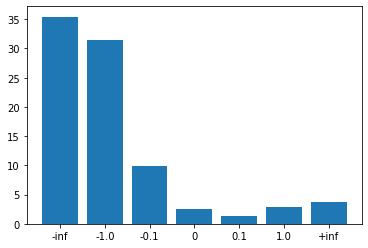

In [92]:
hell_d = [35.43164316829221, 31.515281268279736, 9.885849848745657, 2.567830217165451, 1.4024960668440367, 2.9529449627044273, 3.7107261746317772]
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
plt.bar(q_list, hell_d)
plt.savefig("tsallis_helld_mnist.pdf")

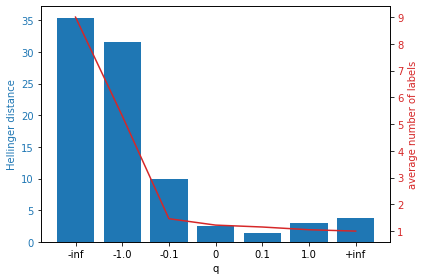

<Figure size 432x288 with 0 Axes>

In [93]:
# from for_graphs.ipynb
lnum = [9.0, 5.3105, 1.464, 1.224, 1.153, 1.051, 1.0]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('q')
ax1.set_ylabel('Hellinger distance', color = color)
ax1.bar(q_list, hell_d, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('average number of labels', color = color)  # we already handled the x-label with ax1
ax2.plot(q_list, lnum, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.savefig("tsallis_dualy_mnist.pdf")

## Top-k graph

[35.141002116644025, 34.47434896598354, 33.652027797408095, 32.60323037539781, 31.2029144763454, 29.20592200097659, 26.06602012792241, 20.258894370553126, 4.162116489974839]


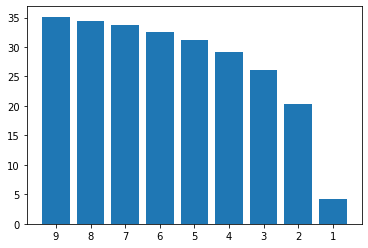

In [94]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)

topk_hell_d = [info_trans_scoring_2(k, classes, orig_A1, lim_A1, dataset) for k in range(9, 0, -1)]
print(topk_hell_d)

plt.bar([str(k) for k in range(9, 0, -1)], topk_hell_d)
plt.savefig("topk_helld_mnist.pdf")

### Top-k (Top-1.2, 1.4, 1.6, 1.8)

In [47]:
classes = [i for i in range(10)]
Rs = [1.2, 1.4, 1.6, 1.8]
dataset = "mnist"

for R in Rs:
    temp = 0
    part = round((R - 1.00)*100)
    for _ in range(5):
        temp += info_trans_scoring_3(part, classes, orig_A1, lim_A1, dataset)
    print(temp/5)

9.820264082966867
13.121544748195493
15.867901911533332
18.117267416937896


## Top-k graph (top-r included)

<BarContainer object of 13 artists>

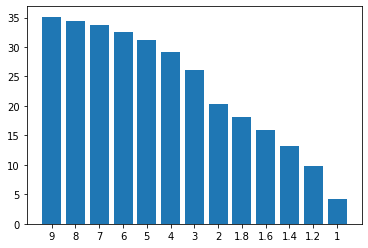

In [52]:
topr_hell_d = [35.141002116644025, 34.47434896598354, 33.652027797408095, 32.60323037539781, 31.2029144763454, 29.20592200097659, 26.06602012792241, 20.258894370553126, 18.117267416937896, 15.867901911533332, 13.121544748195493, 9.820264082966867, 4.162116489974839]
x_axis = [str(k) for k in range(9, 1, -1)] + ["1.8", "1.6", "1.4", "1.2", "1"]
plt.bar(x_axis, topr_hell_d)

# 10 classes, Hellinger distance, Fashion-MNIST

In [101]:
from keras.datasets import fashion_mnist
# loading fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

### q = -1.0, -0.1, 0, 0.1, 1.0 

In [67]:
# main measurement
from math import isnan # for shannon

classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)

q_list = [-1.0, -0.1, 0, 0.1, 1]
dataset = "fmnist"

results = [info_trans_scoring(q, classes, orig_A1, lim_A1, dataset) for q in q_list]
print(results)

[31.831040140800596, 12.068380301185307, 3.06998522427623, 1.5501536602583712, 3.2000566804065045]


### q = +inf (Top-1)

In [36]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "fmnist"

print(info_trans_scoring_2(1, classes, orig_A1, lim_A1, dataset))

4.162116489974839


### q = -inf (Top-9)

In [37]:
print(info_trans_scoring_2(9, classes, orig_A1, lim_A1, dataset))

35.141002116644025


## Tsallis graph

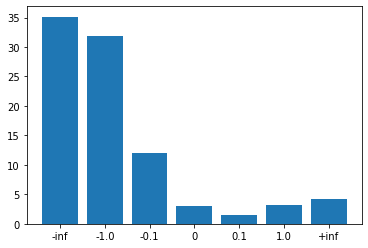

In [102]:
hell_d = [35.141002116644025, 31.831040140800596, 12.068380301185307, 3.06998522427623, 1.5501536602583712, 3.2000566804065045, 4.162116489974839]
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
plt.bar(q_list, hell_d)
plt.savefig("tsallis_helld_fmnist.pdf")

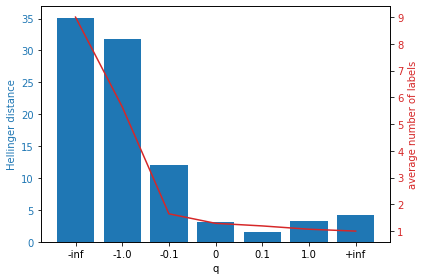

<Figure size 432x288 with 0 Axes>

In [103]:
# from for_graphs.ipynb
lnum = [9.0, 5.648, 1.646, 1.2905, 1.1935, 1.07, 1.0]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('q')
ax1.set_ylabel('Hellinger distance', color = color)
ax1.bar(q_list, hell_d, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('average number of labels', color = color)  # we already handled the x-label with ax1
ax2.plot(q_list, lnum, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.savefig("tsallis_dualy_fmnist.pdf")

## Top-k graph

[35.141002116644025, 34.47434896598354, 33.652027797408095, 32.60323037539781, 31.2029144763454, 29.20592200097659, 26.06602012792241, 20.258894370553126, 4.162116489974839]


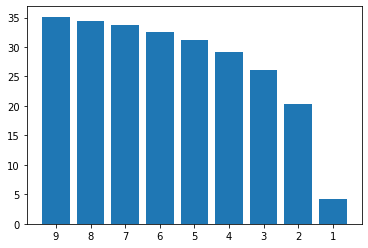

In [104]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "fmnist"

topk_hell_d = [info_trans_scoring_2(k, classes, orig_A1, lim_A1, dataset) for k in range(9, 0, -1)]
print(topk_hell_d)

plt.bar([str(k) for k in range(9, 0, -1)], topk_hell_d)
plt.savefig("topk_helld_fmnist.pdf")

### Top-k (Top-1.2, 1.4, 1.6, 1.8)

In [68]:
classes = [i for i in range(10)]
Rs = [1.2, 1.4, 1.6, 1.8]
dataset = "fmnist"

for R in Rs:
    temp = 0
    part = round((R - 1.00)*100)
    for _ in range(5):
        temp += info_trans_scoring_3(part, classes, orig_A1, lim_A1, dataset)
    print(temp/5)

9.704003943440341
13.214048338453313
15.895665578572357
18.201592060450693


## Top-k graph (top-r included)

<BarContainer object of 13 artists>

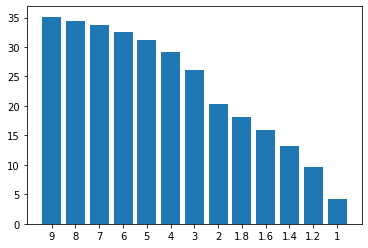

In [69]:
topr_hell_d = [35.141002116644025, 34.47434896598354, 33.652027797408095, 32.60323037539781, 31.2029144763454, 29.20592200097659, 26.06602012792241, 20.258894370553126, 18.201592060450693, 15.895665578572357, 13.214048338453313, 9.704003943440341, 4.162116489974839]
x_axis = [str(k) for k in range(9, 1, -1)] + ["1.8", "1.6", "1.4", "1.2", "1"]
plt.bar(x_axis, topr_hell_d)